# Index

1. [Data loading and preliminary analysis](#1-Data-loading-and-preliminary-analysis)
2. [Analysis of target distribution and data preparation](#2.-Analysis-of-target-distribution-and-data-preparation)
3. [Modeling and evaluation](#3.-Modeling-and-evaluation)

    3.1. [Binary classification](#3.1.-Binary-classification) 
    
    3.2. [Multiclass classification](#3.2.-Multiclass-classification)

4. [Conclusions](#4.-Conclusions)

# 1. Data loading and preliminary analysis

In [81]:
import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns

from skimage.io import imread
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, recall_score, f1_score, precision_score
from sklearn.utils import shuffle, class_weight
from time import time

In [6]:
ROOT_PATH_TRAIN = "./data/can_defects/train"
ROOT_PATH_VALID = "./data/can_defects/valid"
ROOT_PATH_TEST = "./data/can_defects/test"

We define the dimensions of the images to work with them

In [7]:
img_width = 128
img_height = 128

We read the images and create the X and y for each set

In [8]:
def read_data(path, reshape_dim, list_file_name = False):
    
    X = [] 
    y = []
    file_names = []

    for folder in os.listdir(path):
        
        print("Reading files from folder:", folder)
                
        if os.path.isdir('/'.join([path, folder])):

            for file in os.listdir('/'.join([path, folder])):
        
                image = imread('/'.join([path, folder, file]))
                image = image[:, :, :3] # To remove the alpha channel, if applicable
                image = cv2.resize(image, reshape_dim)

                X.append(image)
                y.append(folder)
                
                if list_file_name:
                    
                    file_names.append(file[:-4])
                                        
    if list_file_name:

        return np.array(X), np.array(y), np.array(file_names)
    
    else:
    
        return np.array(X), np.array(y)

In [9]:
X_train, y_train_label = read_data(path=ROOT_PATH_TRAIN, reshape_dim=(img_width, img_height))

Reading files from folder: critical_defect


Reading files from folder: major_defect
Reading files from folder: minor_defect
Reading files from folder: no_defect


In [10]:
print("X_train shape:", X_train.shape)
print("y_train_label shape:", y_train_label.shape)

X_train shape: (5658, 128, 128, 3)
y_train_label shape: (5658,)


In [11]:
X_valid, y_valid_label = read_data(path=ROOT_PATH_VALID, reshape_dim=(img_width, img_height))

Reading files from folder: critical_defect
Reading files from folder: major_defect
Reading files from folder: minor_defect
Reading files from folder: no_defect


In [12]:
print("X_valid shape:", X_valid.shape)
print("y_valid_label shape:", y_valid_label.shape)

X_valid shape: (1609, 128, 128, 3)
y_valid_label shape: (1609,)


In [13]:
X_test, y_test_label, names = read_data(ROOT_PATH_TEST, reshape_dim=(img_width, img_height), list_file_name=True)

Reading files from folder: critical_defect
Reading files from folder: major_defect
Reading files from folder: minor_defect
Reading files from folder: no_defect


In [14]:
print("X_test shape:", X_test.shape)
print("y_test_label shape:", y_test_label.shape)
print("names shape:", names.shape)

X_test shape: (828, 128, 128, 3)
y_test_label shape: (828,)
names shape: (828,)


We display some images with their associated class

In [15]:
def show_images_batch(images, classes = [], n_cols = 5, size_scale = 2):
    
    n_rows = ((len(images) - 1) // n_cols + 1)
    
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    
    for index, image in enumerate(images):
        
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")
        
        if len(classes):
            
            plt.title(classes[index])

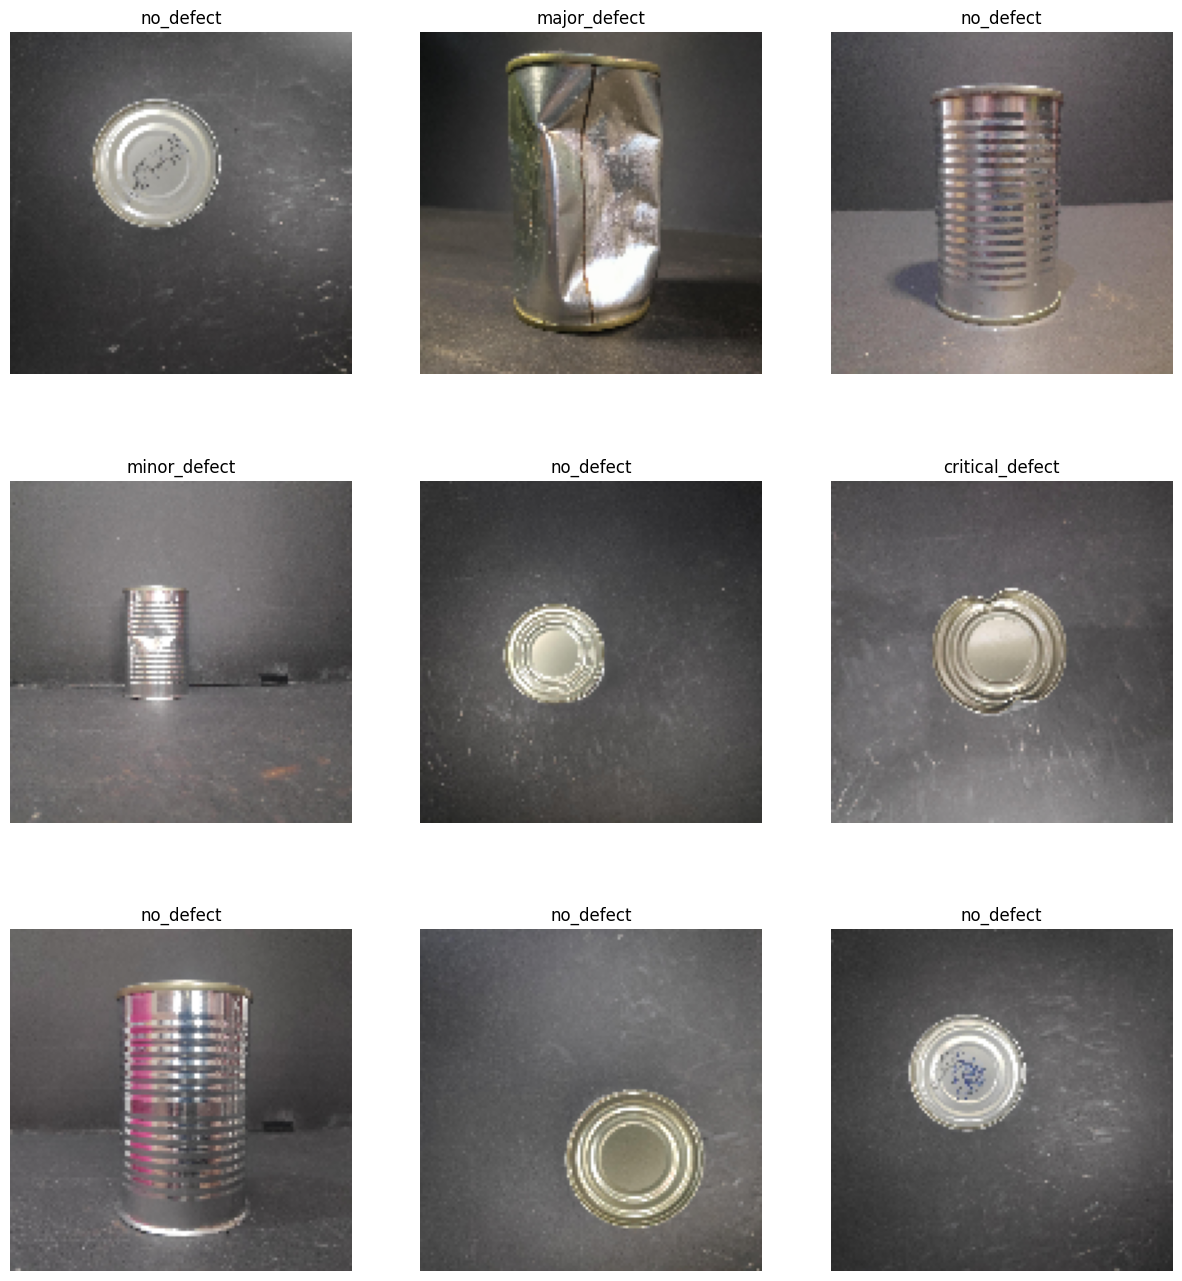

In [16]:
index = np.random.randint(0, len(X_train), 9)
show_images_batch(images = X_train[index], classes = y_train_label[index], n_cols = 3, size_scale = 5)

# 2. Analysis of target distribution and data preparation

We start by evaluating the distribution of each class to choose the appropriate metric

In [17]:
target = pd.Series(y_train_label)
target.value_counts(normalize=True)

minor_defect       0.270414
critical_defect    0.248498
no_defect          0.241075
major_defect       0.240014
Name: proportion, dtype: float64

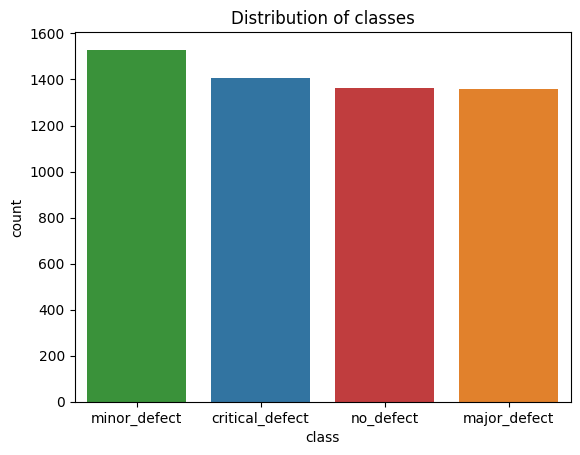

In [18]:
df_target = pd.DataFrame(y_train_label, columns=["class"])
sns.countplot(data=df_target, x="class", order=df_target["class"].value_counts().index, hue=df_target["class"])
plt.title("Distribution of classes");

We have a fairly balanced dataset, although the class "minor_defect" is slightly more prevalent compared to the others. Accuracy will be a good metric to evaluate the model's performance

The first step we will take is a simpler classification based on whether the can is defective or not

In [19]:
y_train_label_binary = [label if label == "no_defect" else "defect" for label in y_train_label]
y_valid_label_binary = [label if label == "no_defect" else "defect" for label in y_valid_label]
y_test_label_binary = [label if label == "no_defect" else "defect" for label in y_test_label]

In [20]:
target_binary = pd.Series(y_train_label_binary)
target_binary.value_counts(normalize=True)

defect       0.758925
no_defect    0.241075
Name: proportion, dtype: float64

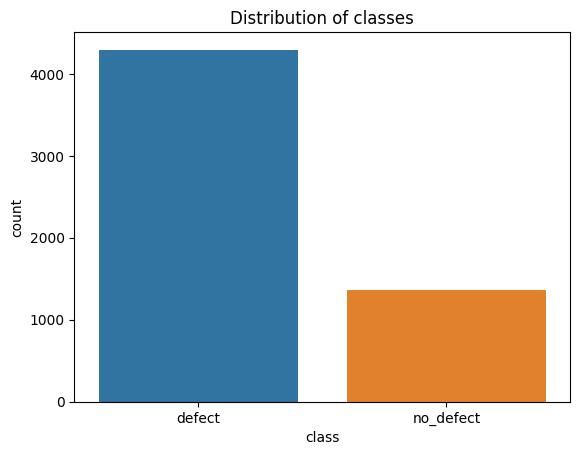

In [21]:
df_target_binary = pd.DataFrame(y_train_label_binary, columns=["class"])
sns.countplot(data=df_target_binary, x="class", order=df_target_binary["class"].value_counts().index, hue=df_target_binary["class"])
plt.title("Distribution of classes");

For this binary grouping, we have an imbalanced dataset. We will use class balancing during training to improve the model's performance

Since we have read the images in order according to each class, we will shuffle the data to prevent the model from learning the order of the data

In [22]:
X_train_s, y_train_label_s = shuffle(X_train, y_train_label, random_state = 42)
X_train_s, y_train_label_binary_s = shuffle(X_train, y_train_label_binary, random_state = 42)

The next step will be to map the classes to convert them into numerical values

In [23]:
# Binary classification
categories_binary = np.unique(y_train_label_binary_s)
n_categories_binary = len(categories_binary)

mapping_binary = {cat: i for i, cat in enumerate(categories_binary)}
inverse_mapping_binary = {valor:clave for clave,valor in mapping_binary.items()}

# Multi classification
categories = np.unique(y_train_label_s)
n_categories = len(categories)

mapping = {cat: i for i, cat in enumerate(categories)}
inverse_mapping = {valor:clave for clave,valor in mapping.items()}


In [24]:
print("Mapping binary:", mapping_binary)
print("Inverse mapping binary:", inverse_mapping_binary)
print("Mapping multi:", mapping)
print("Inverse mapping multi:", inverse_mapping)

Mapping binary: {'defect': 0, 'no_defect': 1}
Inverse mapping binary: {0: 'defect', 1: 'no_defect'}
Mapping multi: {'critical_defect': 0, 'major_defect': 1, 'minor_defect': 2, 'no_defect': 3}
Inverse mapping multi: {0: 'critical_defect', 1: 'major_defect', 2: 'minor_defect', 3: 'no_defect'}


In [25]:
# Train set
y_train_num_binary_s = np.array([mapping_binary[cat] for cat in y_train_label_binary_s])
y_train_num_s = np.array([mapping[cat] for cat in y_train_label_s])

# Validation set
y_valid_num_binary = np.array([mapping_binary[cat] for cat in y_valid_label_binary])
y_valid_num = np.array([mapping[cat] for cat in y_valid_label])

# Test set
y_test_num_binary = np.array([mapping_binary[cat] for cat in y_test_label_binary])
y_test_num = np.array([mapping[cat] for cat in y_test_label])

Finally, we will scale the data to a range of values between 0 and 1

In [26]:
X_train_s = X_train_s/255
X_valid = X_valid/255
X_test = X_test/255

# 3. Modeling and evaluation

## 3.1. Binary classification 

First, we will create the model for binary classification

In [52]:
binary_model = keras.Sequential()

#First convolutional layer and pooling
binary_model.add(keras.layers.Conv2D(filters = 8, kernel_size = (5, 5), strides = 2, input_shape = X_train[0].shape, padding = "same", activation = 'relu'))
binary_model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = 2))

# Dropout layer
binary_model.add(keras.layers.Dropout(0.5))

# Second convolutional layer and pooling
binary_model.add(keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = 2, padding = "same", activation = 'relu'))
binary_model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = 2))

# Dropout layer
binary_model.add(keras.layers.Dropout(0.5))

# Flatten layer to convert the output from the pooling layer into a vector
binary_model.add(keras.layers.Flatten())

# First hidden dense layer
binary_model.add(keras.layers.Dense(units = 1024, activation = 'relu'))

# Dropout layer
binary_model.add(keras.layers.Dropout(0.5))

# Output layer
binary_model.add(keras.layers.Dense(units = 1, activation='sigmoid'))

# Compiler
binary_model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['acc'])

c:\Users\7681\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [53]:
binary_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 8)      │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,052,401 (4.01 MB)

 Trainable params: 1,052,401 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

We define the early stopping by monitoring validation accuracy

In [54]:
early_stop_binary = keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 10, restore_best_weights = True)

We choose the batch size aiming for 100 steps per epoch

In [55]:
instancies_train = len(X_train_s)

for i in range(1,10):
    print(f"Batch_size: {8*i}, num_steps_per_epoch: {round(0.8*instancies_train/(8*i))}")

Batch_size: 8, num_steps_per_epoch: 566
Batch_size: 16, num_steps_per_epoch: 283
Batch_size: 24, num_steps_per_epoch: 189
Batch_size: 32, num_steps_per_epoch: 141
Batch_size: 40, num_steps_per_epoch: 113
Batch_size: 48, num_steps_per_epoch: 94
Batch_size: 56, num_steps_per_epoch: 81
Batch_size: 64, num_steps_per_epoch: 71
Batch_size: 72, num_steps_per_epoch: 63


In [56]:
batch_size = 40

We calculate the weights for class imbalance and train the model

In [57]:
cls_wgts = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_num_binary_s), y=y_train_num_binary_s)
cls_wgts = {i : cls_wgts[i] for i, label in enumerate(sorted(np.unique(y_train_num_binary_s)))}

print("Class weights:", cls_wgts)

Class weights: {0: 0.6588262692128551, 1: 2.0740469208211145}


In [58]:
t_zero = time()

history_binary = binary_model.fit(X_train_s, 
                    y_train_num_binary_s,
                    batch_size = batch_size,
                    validation_split = 0.2,
                    class_weight = cls_wgts,
                    epochs = 100,
                    callbacks = [early_stop_binary])

time_train_binary = time()-t_zero

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - acc: 0.5901 - loss: 0.6865 - val_acc: 0.7191 - val_loss: 0.5276
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.7011 - loss: 0.5533 - val_acc: 0.7367 - val_loss: 0.4434
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.6771 - loss: 0.5379 - val_acc: 0.6687 - val_loss: 0.5322
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.7230 - loss: 0.4740 - val_acc: 0.7597 - val_loss: 0.4344
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.7861 - loss: 0.4008 - val_acc: 0.7041 - val_loss: 0.5094
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.7966 - loss: 0.3757 - val_acc: 0.6528 - val_loss: 0.5541
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.8225 - loss: 0.3367 - val_acc: 0.7297 - val_loss: 0.4582
Epoch 8/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.8607 - loss: 0.2971 - val_acc: 0.8534 - val_loss: 0.2873
Epoch 9/100
114/114 ━━━━━━━━━━━━━━━━━━━━

In [59]:
print(f"traning time: {round(time_train_binary // 60)} minutes and {round(time_train_binary % 60)} seconds")

traning time: 2 minutes and 55 seconds


We visualize the training progress

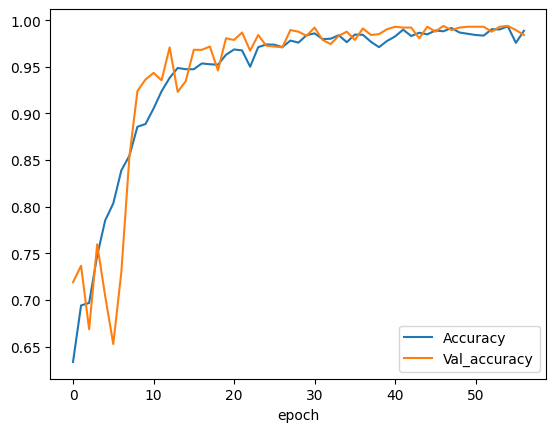

In [60]:
history_df_binary = pd.DataFrame(history_binary.history)

plt.plot(history_df_binary['acc'], label = 'Accuracy')
plt.plot(history_df_binary['val_acc'], label = 'Val_accuracy')
plt.xlabel('epoch')
plt.legend();

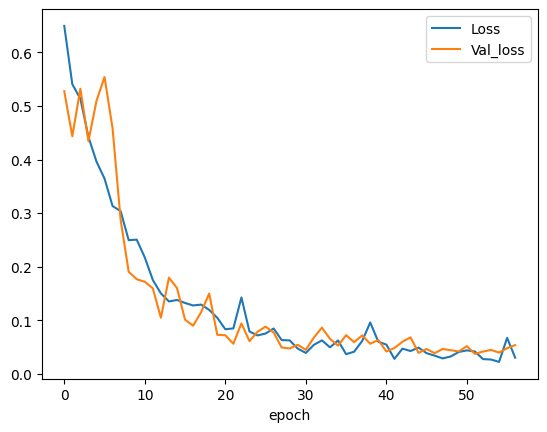

In [61]:
plt.plot(history_df_binary['loss'], label = 'Loss')
plt.plot(history_df_binary['val_loss'], label = 'Val_loss')
plt.xlabel('epoch')

plt.legend();

It can be observed that from epoch 30 onwards, we do not achieve significantly better results for validation accuracy, and the loss function stabilizes for both training and validation (in this case, validation set is the 20% of train set)

Let's evaluate using the validation set

In [62]:
results_valid_binary = binary_model.evaluate(X_valid, y_valid_num_binary)
print(f"Validation accuracy: {round(results_valid_binary[1]*100,2)}%")

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9995 - loss: 0.0108
Validation accuracy: 99.88%


The evaluation considers threshold = 0.5 for deciding the class and calculate the *accuracy*. Additionaly, we can analyze the threshold where we obtain the best results regarding to F1 score (looking for a balance between precision and recall)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Max F1: 0.9974, threshold: 0.53


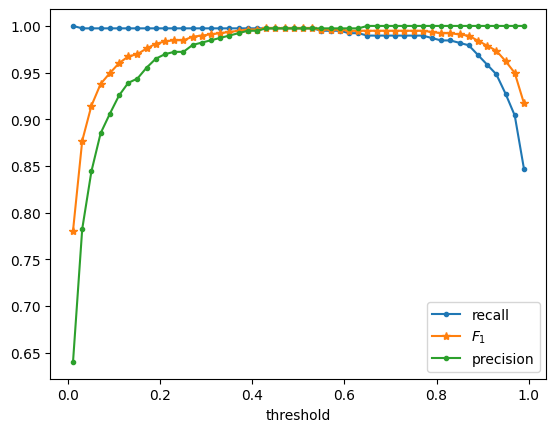

In [63]:
predictions_valid_binary = binary_model.predict(X_valid)

range_threshold = np.linspace(0.01,0.99)

recall = [0]*len(range_threshold)
f1 = [0]*len(range_threshold)
precision = [0]*len(range_threshold)

threshold_max_f1 = 0
max_f1 = 0
for i in range(len(range_threshold)):
    
    y_pred_rp_curve = predictions_valid_binary > range_threshold[i]
    
    precision[i] = precision_score(y_valid_num_binary, y_pred_rp_curve)
    recall[i] = recall_score(y_valid_num_binary, y_pred_rp_curve)
    f1[i] = f1_score(y_valid_num_binary, y_pred_rp_curve)
    
    if f1[i] > max_f1:
        threshold_max_f1 = round(range_threshold[i], 4)
        max_f1 = round(f1[i], 4)    

plt.plot(range_threshold, recall,'.-')
plt.plot(range_threshold, f1,'*-')
plt.plot(range_threshold, precision,'.-')

plt.xlabel('threshold')
plt.legend(['recall','$F_1$','precision']);

print(f"Max F1: {max_f1}, threshold: {threshold_max_f1}")

It's very close to 0.5, but we will use the threshold obtained for the best F1 metric and display the results

In [64]:
threshold = threshold_max_f1

In [65]:
y_pred_num_binary = [1 if prediction > threshold else 0 for prediction in predictions_valid_binary]
y_pred_label_binary = [inverse_mapping_binary[y] for y in y_pred_num_binary]

In [66]:
print(classification_report(y_valid_label_binary, y_pred_label_binary))

              precision    recall  f1-score   support

      defect       1.00      1.00      1.00      1223
   no_defect       1.00      1.00      1.00       386

    accuracy                           1.00      1609
   macro avg       1.00      1.00      1.00      1609
weighted avg       1.00      1.00      1.00      1609



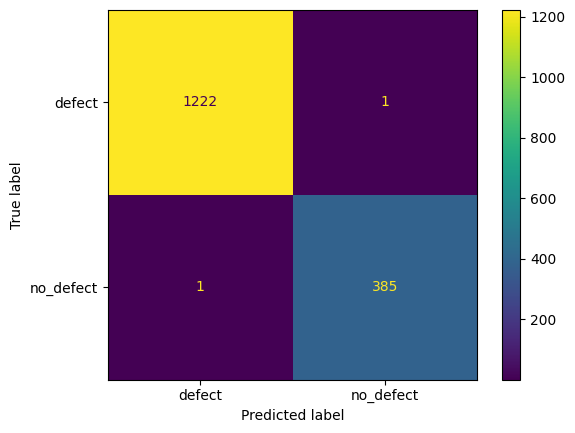

In [67]:
ConfusionMatrixDisplay.from_predictions(y_valid_label_binary, y_pred_label_binary);

In this case, and given that we had a very good initial accuracy, the gain we obtain by choosing the threshold is practically negligible, but it could be interesting in the case of a model with worse performance

Finally, we evaluate using the test set and the threshold for the best F1 score

In [97]:
predictions_test_binary = binary_model.predict(X_test)
y_pred_num_binary = [1 if prediction > threshold else 0 for prediction in predictions_test_binary]
y_pred_label_binary = [inverse_mapping_binary[y] for y in y_pred_num_binary]

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [98]:
print(classification_report(y_test_label_binary, y_pred_label_binary))

              precision    recall  f1-score   support

      defect       1.00      1.00      1.00       629
   no_defect       0.99      0.99      0.99       199

    accuracy                           1.00       828
   macro avg       1.00      0.99      1.00       828
weighted avg       1.00      1.00      1.00       828



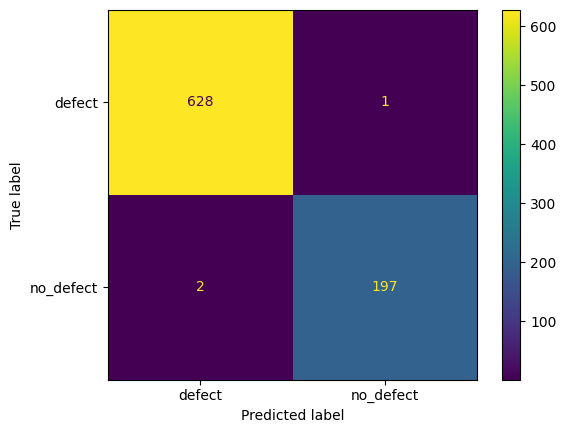

In [99]:
ConfusionMatrixDisplay.from_predictions(y_test_label_binary, y_pred_label_binary);

As expected, we are obtaining very good results, and even the errors are balanced

If we display the errors made by the model when evaluating the test set

In [100]:
values = binary_model.predict(X_test).flatten().round(3)

pred_df_binary = pd.DataFrame({"File_name": names, "True": y_test_label_binary, "Predicted": y_pred_label_binary, "Value": values})

incorrect = pred_df_binary["True"] != pred_df_binary["Predicted"]
df_incorrect_binary = pred_df_binary[incorrect]

df_incorrect_binary

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,File_name,True,Predicted,Value
403,IMG_20220709_173850_jpg.rf.cb8d8860b08d7aae451...,defect,no_defect,0.848
642,IMG_20220624_153303_jpg.rf.9fe31465c8f50a373cc...,no_defect,defect,0.000
648,IMG_20220624_154039_jpg.rf.1f167a06dcb429242df...,no_defect,defect,0.068


In [72]:
def plot_image_confidence(images, df):
        
    num_images = len(df.index.tolist())
    
    cols = 4
    if (num_images/cols) % 2 != 0:
        
        rows = num_images//cols + 1
    else:
        
        rows = num_images//cols


    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*4))
    axes = axes.flatten()

    
    for i, index in enumerate(df.index.tolist()):

        axes[i].imshow(images[index]);
        axes[i].set_title(f"True: {df.iloc[i,1]} \n Predicted: {df.iloc[i,2]} \n Value: {df.iloc[i,3].astype(float).round(3)}")
    

    for i in range(rows*cols):
        axes[i].axis("Off")

    plt.tight_layout()
    plt.show()

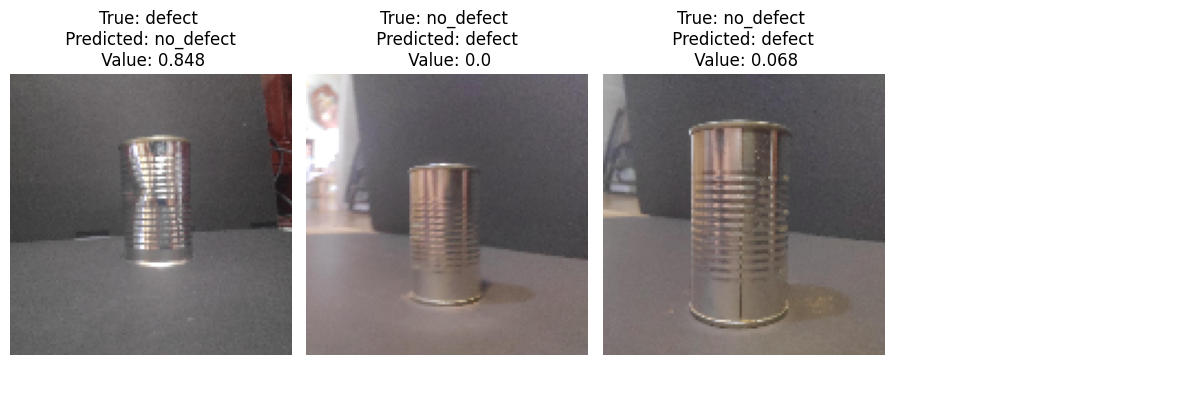

In [101]:
plot_image_confidence(X_test, df = df_incorrect_binary)

Finally, we save the model so that we can use it again and pre-trained

In [102]:
binary_model.save("./models/model_binary/model_binary.keras")

In [103]:
binary_model = keras.models.load_model("./models/model_binary/model_binary.keras")

## 3.2. Multiclass classification 

This time, we are going to do a multiclass classification. We create the model for this purpose

In [128]:
multi_model = keras.Sequential()

#First convolutional layer and pooling
multi_model.add(keras.layers.Conv2D(filters = 8, kernel_size = (5, 5), strides = 2, input_shape = X_train[0].shape, padding = "same", activation = 'relu'))
multi_model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = 2))

# Dropout layer
multi_model.add(keras.layers.Dropout(0.5))

# Second convolutional layer and pooling
multi_model.add(keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = 2, padding = "same", activation = 'relu'))
multi_model.add(keras.layers.MaxPool2D(pool_size = (2,2), strides = 2))

# Dropout layer
multi_model.add(keras.layers.Dropout(0.5))

# Flatten layer to convert the output from the pooling layer into a vector
multi_model.add(keras.layers.Flatten())

# First hidden dense layer
multi_model.add(keras.layers.Dense(units = 1024, activation = 'relu'))

# Dropout layer
multi_model.add(keras.layers.Dropout(0.5))

# Output layer
multi_model.add(keras.layers.Dense(units = 4, activation='softmax'))

# Compiler
multi_model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


In [129]:
multi_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 8)      │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,055,476 (4.03 MB)

 Trainable params: 1,055,476 (4.03 MB)

 Non-trainable params: 0 (0.00 B)

As previously, we define the early stopping by monitoring validation accuracy

In [130]:
early_stop_multi = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True)

It is not necessary to calculate the weights for class imbalance because all four classes are balanced, so we train the model

In [131]:
t_zero = time()

history_multi = multi_model.fit(X_train_s, 
                    y_train_num_s,
                    batch_size = batch_size,
                    validation_split = 0.2,
                    epochs = 100,
                    callbacks = [early_stop_multi])

time_train_multi = time()-t_zero

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.3182 - loss: 1.4065 - val_accuracy: 0.4982 - val_loss: 1.2546
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4616 - loss: 1.1919 - val_accuracy: 0.5760 - val_loss: 1.0732
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5290 - loss: 1.0520 - val_accuracy: 0.6581 - val_loss: 0.9272
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6029 - loss: 0.9214 - val_accuracy: 0.7270 - val_loss: 0.7451
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6693 - loss: 0.8074 - val_accuracy: 0.7535 - val_loss: 0.7027
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7130 - loss: 0.7086 - val_accuracy: 0.7765 - val_loss: 0.6083
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7457 - loss: 0.6298 - val_accuracy: 0.8375 - val_loss: 0.5393
Epoch 8/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7662 - loss: 0.5968 - 

In [132]:
print(f"traning time: {round(time_train_multi // 60)} minutes and {round(time_train_multi % 60)} seconds")

traning time: 3 minutes and 59 seconds


We visualize the training progress

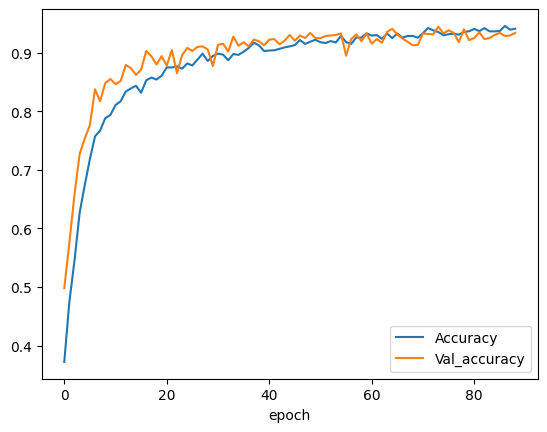

In [133]:
history_df = pd.DataFrame(history_multi.history)

plt.plot(history_df['accuracy'], label = 'Accuracy')
plt.plot(history_df['val_accuracy'], label = 'Val_accuracy')
plt.xlabel('epoch')
plt.legend();

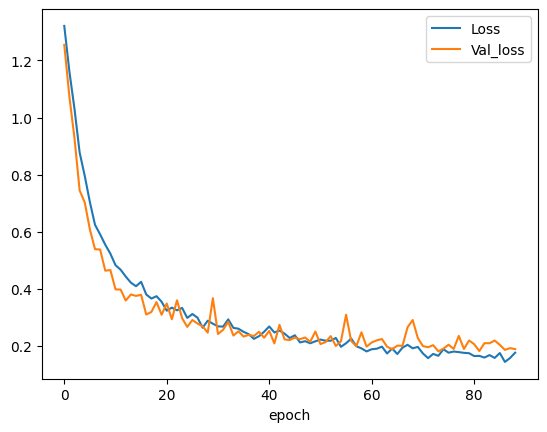

In [134]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')
plt.xlabel('epoch')

plt.legend();

As for binary classification we have very good results and, this time from epoch 40 onwards, we do not achieve significantly better results for validation accuracy, and the loss function stabilizes for both training and validation (in this case, validation set is the 20% of train set)

Let's evaluate using both validation and test sets

**Validation set**

In [135]:
results_valid_multi = multi_model.evaluate(X_valid, y_valid_num)
print(f"Validation accuracy: {round(results_valid_multi[1]*100,2)}%")

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8942 - loss: 0.2483
Validation accuracy: 93.97%


In [136]:
y_pred_num = [np.argmax(predictions) for predictions in multi_model.predict(X_valid)]
y_pred_label = [inverse_mapping[y] for y in y_pred_num]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [137]:
print(classification_report(y_valid_label, y_pred_label))

                 precision    recall  f1-score   support

critical_defect       0.96      0.92      0.94       401
   major_defect       0.90      0.93      0.91       385
   minor_defect       0.91      0.92      0.92       437
      no_defect       0.99      1.00      1.00       386

       accuracy                           0.94      1609
      macro avg       0.94      0.94      0.94      1609
   weighted avg       0.94      0.94      0.94      1609



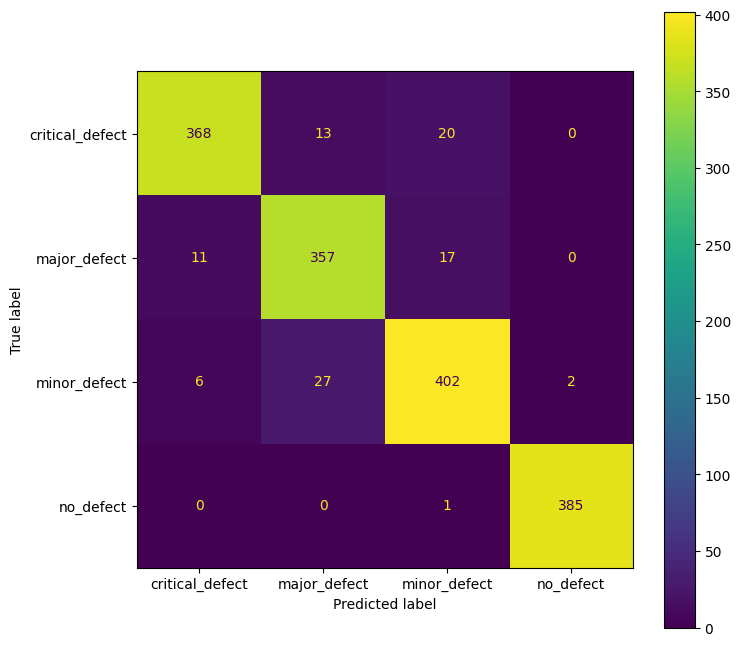

In [138]:
fig,axs = plt.subplots(1,1,figsize = (8,8))
ConfusionMatrixDisplay.from_predictions(y_valid_label, y_pred_label, ax=axs);

We found that the model, within the small percentage of error it has, mostly makes mistakes in predicting one class with its contiguous class (except for the class 'critical_defect,' where it confuses it more with the class 'minor_defect' than with the class 'major_defect')

Additionally, only in one case it confuses the class 'no_defect' with a class associated with some defect, in this case 'minor_defect'

**Test set**

In [139]:
results_test_multi = multi_model.evaluate(X_test, y_test_num)
print(f"Test accuracy: {round(results_test_multi[1]*100,2)}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8652 - loss: 0.3185
Test accuracy: 92.51%


In [140]:
y_pred_num = [np.argmax(predictions) for predictions in multi_model.predict(X_test)]
y_pred_label = [inverse_mapping[y] for y in y_pred_num]


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [141]:
print(classification_report(y_test_label, y_pred_label))

                 precision    recall  f1-score   support

critical_defect       0.94      0.89      0.91       202
   major_defect       0.88      0.92      0.90       200
   minor_defect       0.89      0.90      0.90       227
      no_defect       1.00      0.99      0.99       199

       accuracy                           0.93       828
      macro avg       0.93      0.93      0.93       828
   weighted avg       0.93      0.93      0.93       828



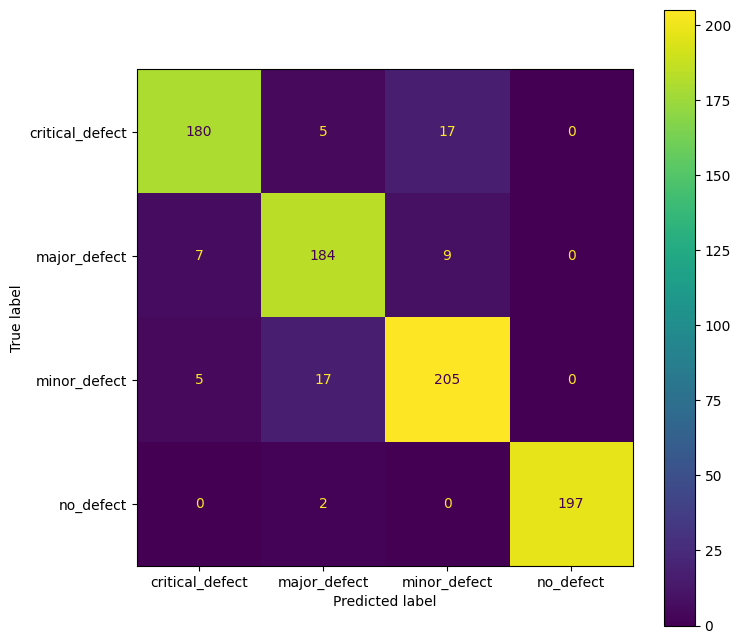

In [142]:
fig,axs = plt.subplots(1,1,figsize = (8,8))
ConfusionMatrixDisplay.from_predictions(y_test_label, y_pred_label, ax=axs);

We obtain similar results and conclusions as in the previous evaluation using valid set, but this time the model confuses the class 'no_defect' with a class associated with some defect twice, in this case 'major_defect'

If we display the errors made by the model when evaluating the test set

In [153]:
confidence = [max(prediction) for prediction in multi_model.predict(X_test)]

pred_df_multi = pd.DataFrame({"File_name": names, "True": y_test_label, "Predicted": y_pred_label, "Confidence": confidence})

incorrect = pred_df_multi["True"] != pred_df_multi["Predicted"]
df_incorrect_multi = pred_df_multi[incorrect]

df_incorrect_multi

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,File_name,True,Predicted,Confidence
1,IMG_20220709_192600_jpg.rf.7451ff1ce7ee88a179b...,critical_defect,major_defect,0.576411
6,IMG_20220709_193612_jpg.rf.5c52e890fc760ebfea9...,critical_defect,minor_defect,0.594082
8,IMG_20220924_192646_jpg.rf.f3594c381c14a7d0725...,critical_defect,minor_defect,0.431115
9,IMG_20220924_193930_jpg.rf.ab12493648681713805...,critical_defect,minor_defect,0.801662
10,IMG_20220924_193953_jpg.rf.f1e21d7c14ef22e2457...,critical_defect,minor_defect,0.683273
...,...,...,...,...
516,IMG_20220924_182649_jpg.rf.b1ee830cf5677b47329...,minor_defect,major_defect,0.711653
518,IMG_20220924_183729_jpg.rf.8baea103e2f737c6ff5...,minor_defect,critical_defect,0.717910
523,IMG_20220925_173026_jpg.rf.5301a004b590a8d11ff...,minor_defect,major_defect,0.843266
642,IMG_20220624_153303_jpg.rf.9fe31465c8f50a373cc...,no_defect,major_defect,0.999422


In [144]:
def plot_image_confidence(images, labels, predictions, map):

    # Calculamos el número de imágenes
    num_images = len(images)

    # Creamos una cuadrícula de subplots
    rows = num_images
    cols = 2

    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*5))
    axes = axes.flatten()

    for i in range(num_images):

            # Mostramos la imagen
            axes[2*i].imshow(images[i], cmap='Greys');
            
            # Colocamos el título con el valor de la etiqueta
            label_pred = np.argmax(predictions[i])
            axes[2*i].set_title(f"True: {map.get(labels[i])} \n Predicted: {map.get(label_pred)} (Confidence: {round(predictions[i].max()*100,2)}%)")

            
            # Quitamos los números de los ejes
            axes[2*i].set_yticklabels([])
            axes[2*i].set_xticklabels([])
            
            # Mostramos el grafico con las confianzas calculadas por el modelo
            axes[(2*i)+1].bar(map.values(), predictions[i])
            
            # Mostramos el título
            axes[(2*i)+1].set_title("Confidence")

    plt.tight_layout()
    plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


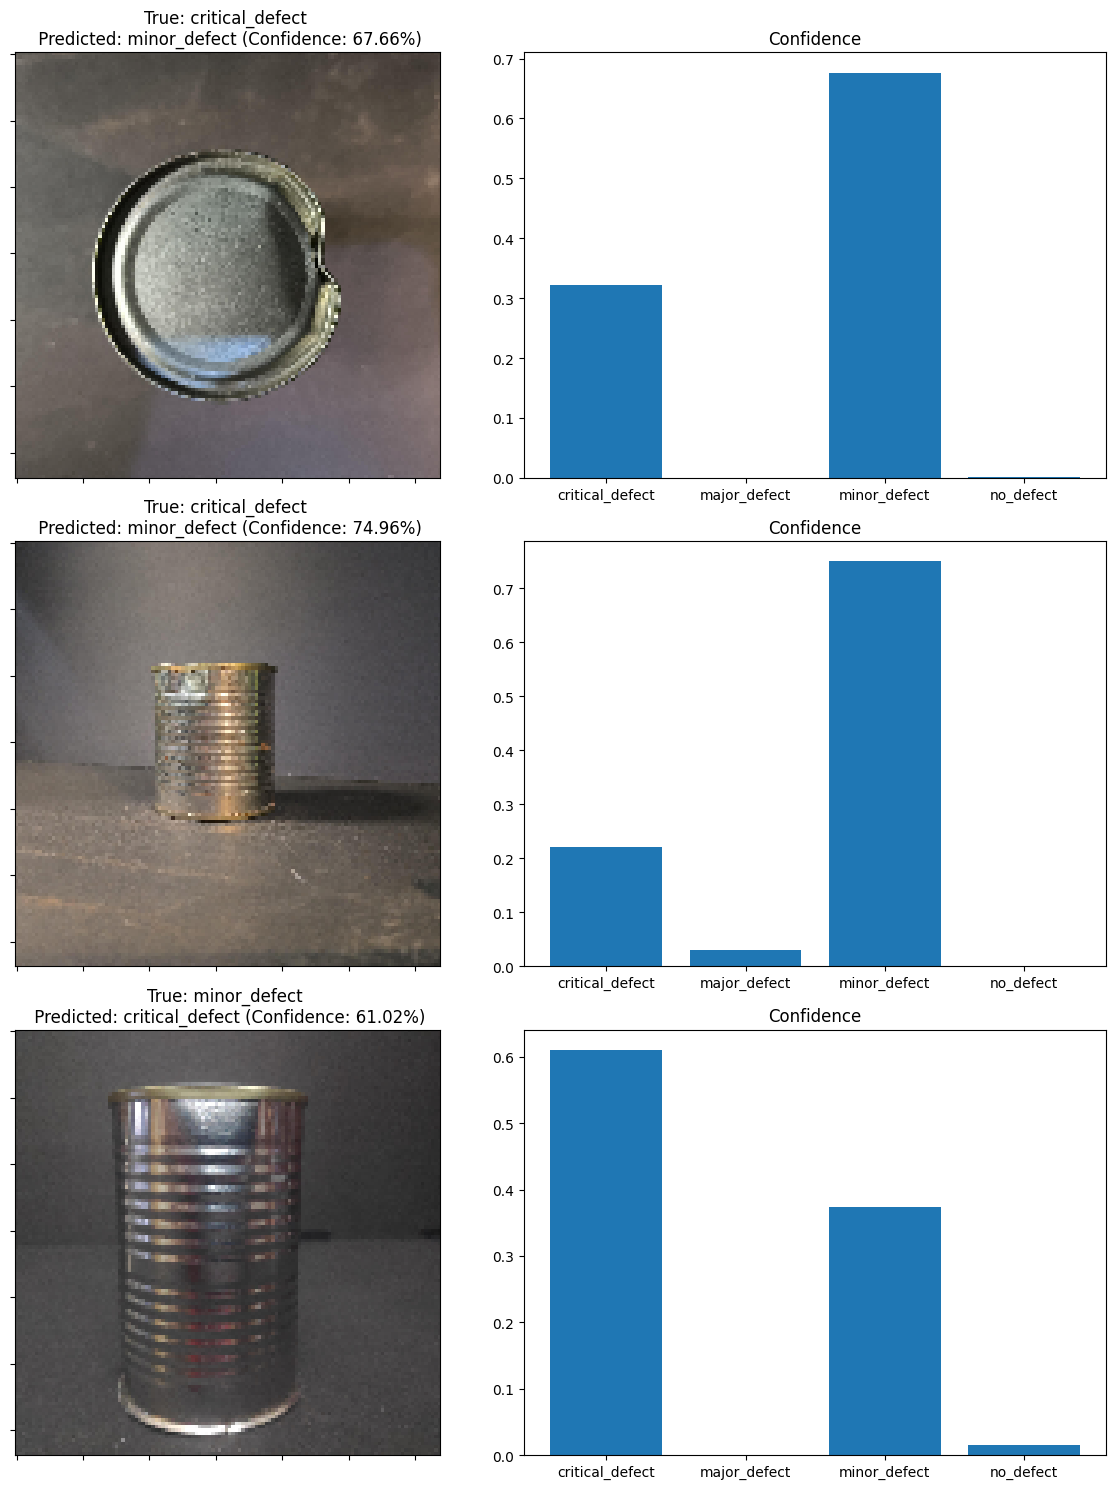

In [163]:
predictions = multi_model.predict(X_test)
index = random.sample(df_incorrect_multi.index.to_list(), 3) #Show only 3 mistakes

plot_image_confidence(X_test[index], y_test_num[index], predictions[index], map=inverse_mapping)

Finally, we save the model so that we can use it again and pre-trained

In [164]:
multi_model.save("./models/model_multi/model_multi.keras")

In [165]:
multi_model = keras.models.load_model("./models/model_multi/model_multi.keras")

# 4. Conclusions

XXXX